# MNIST Code Along with CNN
Now that we've seen the results of an artificial neural network model on the <a href='https://en.wikipedia.org/wiki/MNIST_database'>MNIST dataset</a>, let's work the same data with a <a href='https://en.wikipedia.org/wiki/Convolutional_neural_network'>Convolutional Neural Network</a> (CNN).
Make sure to watch the theory lectures! You'll want to be comfortable with:
* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

Note that in this exercise there is no need to flatten the MNIST data, as a CNN expects 2-dimensional data.

## Perform standard imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Load the MNIST dataset
PyTorch makes the MNIST train and test datasets available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. The first time they're called, the datasets will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.

Refer to the previous section for explanations of transformations, batch sizes and <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [100]:
(train_data[2000][0])

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [4]:
train_data[2000]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [5]:
type(test_data)

torchvision.datasets.mnist.MNIST

In [6]:
len(test_data)

10000

In [102]:
(test_data[1000][0]).shape, type(test_data[1000][0])

(torch.Size([1, 28, 28]), torch.Tensor)

### Create loaders
When working with images, we want relatively small batches; a batch size of 4 is not uncommon.

In [8]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [9]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

## Define a convolutional model
In the previous section we used only fully connected layers, with an input layer of 784 (our flattened 28x28 images), hidden layers of 120 and 84 neurons, and an output size representing 10 possible digits.

This time we'll employ two convolutional layers and two pooling layers before feeding data through fully connected hidden layers to our output. The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take.</strong><br>

1. Extend the base Module class:
   
<tt><font color=black>class ConvolutionalNetwork(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the convolutional layers with <a href='https://pytorch.org/docs/stable/nn.html#conv2d'><tt><strong>torch.nn.Conv2d()</strong></tt></a><br><br>The first layer has one input channel (the grayscale color channel). We'll assign 6 output channels for feature extraction. We'll set our kernel size to 3 to make a 3x3 filter, and set the step size to 1.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv1 = nn.Conv2d(1, 6, 3, 1)</font></tt><br>
The second layer will take our 6 input channels and deliver 16 output channels.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv2 = nn.Conv2d(6, 16, 3, 1)</font></tt><br><br>

3. Set up the fully connected layers with <a href='https://pytorch.org/docs/stable/nn.html#linear'><tt><strong>torch.nn.Linear()</strong></tt></a>.<br><br>The input size of (5x5x16) is determined by the effect of our kernels on the input image size. A 3x3 filter applied to a 28x28 image leaves a 1-pixel edge on all four sides. In one layer the size changes from 28x28 to 26x26. We could address this with zero-padding, but since an MNIST image is mostly black at the edges, we should be safe ignoring these pixels. We'll apply the kernel twice, and apply pooling layers twice, so our resulting output will be 
$\;(((28-2)/2)-2)/2 = 5.5\;$ which rounds down to 5 pixels per side.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc1 = nn.Linear(5\*5\*16, 120)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc2 = nn.Linear(120, 84)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc3 = nn.Linear(84, 10)</font></tt><br>
See below for a more detailed look at this step.<br><br>

4. Define the forward method.<br><br>Activations can be applied to the convolutions in one line using <a href='https://pytorch.org/docs/stable/nn.html#id27'><tt><strong>F.relu()</strong></tt></a> and pooling is done using <a href='https://pytorch.org/docs/stable/nn.html#maxpool2d'><tt><strong>F.max_pool2d()</strong></tt></a><br>
<tt><font color=black>def forward(self, X):<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv2(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
</font></tt>Flatten the data for the fully connected layers:<br><tt><font color=black>
&nbsp;&nbsp;&nbsp;&nbsp;X = X.view(-1, 5\*5\*16)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.fc1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = self.fc2(X)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return F.log_softmax(X, dim=1)</font></tt>
</div>

<div class="alert alert-danger"><strong>Breaking down the convolutional layers</strong> (this code is for illustration purposes only.)</div>

In [10]:
# Define layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [11]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break

In [12]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


In [13]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)

torch.Size([1, 6, 26, 26])


In [14]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 6, 13, 13])


In [15]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [16]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 5, 5])


In [17]:
# Flatten the data
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


<div class="alert alert-danger"><strong>This is how the convolution output is passed into the fully connected layers.</strong></div>

Now let's run the code.

In [18]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [19]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Including the bias terms for each layer, the total number of parameters being trained is:<br>

$\quad\begin{split}(1\times6\times3\times3)+6+(6\times16\times3\times3)+16+(400\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
54+6+864+16+48000+120+10080+84+840+10 &= 60,074\end{split}$<br>

In [20]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [21]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


## Define loss function & optimizer

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model
This time we'll feed the data directly into the model without flattening it first.

In [23]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.21157125  accuracy:  78.233%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.57967848  accuracy:  85.442%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.05560564  accuracy:  88.578%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.03419421  accuracy:  90.388%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.01033590  accuracy:  91.573%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00574748  accuracy:  92.364%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.05399729  accuracy:  92.924%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00293207  accuracy:  93.448%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00047731  accuracy:  93.870%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00576317  accuracy:  94.233%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.03618915  accuracy:  97.967%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.33146057  accuracy:  97.850%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.22193006  accuracy:  97.856%
epoch:  1  b

In [24]:
torch.save(model.state_dict(), 'model_ft.pth')

## Plot the loss and accuracy comparisons

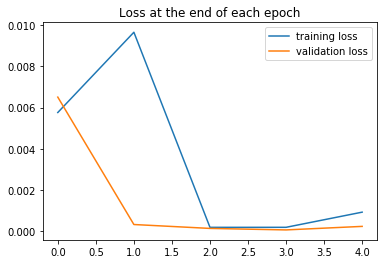

In [25]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [26]:
test_losses

[tensor(0.0065),
 tensor(0.0003),
 tensor(0.0001),
 tensor(6.4701e-05),
 tensor(0.0002)]

While there may be some overfitting of the training data, there is far less than we saw with the ANN model.

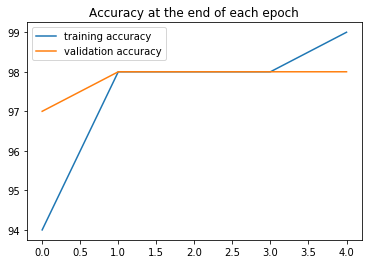

In [27]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [28]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [29]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9848/10000 =  98.480%


Recall that our [784,120,84,10] ANN returned an accuracy of 97.25% after 10 epochs. And it used 105,214 parameters to our current 60,074.

## Display the confusion matrix

In [30]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 978    0    3    2    0    2    5    1   12    2]
 [   0 1130    8    1    0    0    2    2    0    0]
 [   0    0 1011    2    0    0    1    3    2    0]
 [   0    1    1  998    0    8    0    0    2    3]
 [   0    0    2    0  975    0    3    0    0    4]
 [   0    0    0    4    0  870    1    0    1    2]
 [   1    1    0    0    2    6  945    0    3    1]
 [   0    1    6    1    0    1    0 1004    3    3]
 [   0    2    1    2    1    0    1    0  946    3]
 [   1    0    0    0    4    5    0   18    5  991]]


## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [31]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

152

In [32]:
# Display the first 10 index positions
misses[:10]

array([  18,   36,  158,  184,  259,  321,  340,  445,  448,  449],
      dtype=int64)

In [33]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Now that everything is set up, run and re-run the cell below to view all of the missed predictions.<br>
Use <kbd>Ctrl+Enter</kbd> to remain on the cell between runs. You'll see a <tt>StopIteration</tt> once all the misses have been seen.

Index: [  18   36  158  184  259  321  340  445  448  449  460  495]
Label: [   3    7    3    8    6    2    5    6    9    3    5    8]
Guess: [   5    2    0    3    0    7    3    0    8    5    9    0]


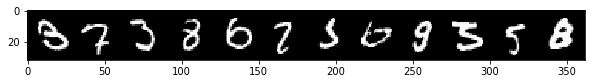

In [34]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Run a new image through the model
We can also pass a single image through the model to obtain a prediction.
Pick a number from 0 to 9999, assign it to "x", and we'll use that value to select a number from the MNIST test set.

import pickle

model = pickle.load(open("final_model.sav", "rb"))

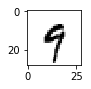

In [35]:
x = 2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [36]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 9


In [37]:
x1 = test_data[2000][0].view(1,1,28,28)

In [38]:
x1.shape

torch.Size([1, 1, 28, 28])

## Great job!

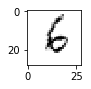

In [39]:
# converting my own images into tensors and then, using the model to make the prediction.
x = 2000
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap='gist_yarg');

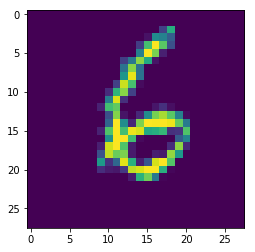

In [40]:
plt.imshow(test_data[2000][0].reshape((28,28)))

In [41]:
mean_2000 = (test_data[2000][0].reshape((28,28)))

In [42]:
mean_2000.shape

torch.Size([28, 28])

In [43]:
mean_2000.mean()

tensor(0.0819)

In [44]:
mean_3 = (test_data[2300][0].reshape((28,28)))

In [45]:
mean_3.mean()

tensor(0.1484)

# Read in the image

In [1]:
import cv2
import os

In [2]:
IMG_DIR = 'C:/Users/Billi/repos/sudoku/images/Square1'

In [3]:
filenames = os.listdir(IMG_DIR)
#filenames.sort()
final_images = []
for images in filenames:
    img_array = cv2.imread(os.path.join(IMG_DIR, images))
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    resize_img = cv2.resize(img_array, (28,28))
    final_images.append(resize_img)

In [4]:
plt.imshow(final_images[0])

NameError: name 'plt' is not defined

In [5]:
transform = transforms.ToTensor()
tensor_images = []
for images in final_images:
    tensors = torch.tensor(images, dtype=torch.float)
    tensor_images.append(tensors)


NameError: name 'transforms' is not defined

In [51]:
type(tensor_images[2]), tensor_images[0].mean()

(torch.Tensor, tensor(29.4439))

In [103]:
tensor_images[2].shape

torch.Size([28, 28])

In [108]:
(type(train_data[2000][1]))

int

In [52]:
new_pred = model(tensor_images[79].view(1,1,28,28)).argmax()

In [53]:
type(new_pred.item())

int

In [54]:
tensor_images[4].mean()

tensor(17.9809)

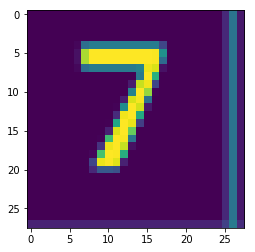

In [55]:
plt.imshow(tensor_images[2])

In [56]:
print("Prediction:", new_pred.item())

Prediction: 0


In [57]:
def convert(tensor): # always be passing in an array
    grid = []
    for i in range(len(tensor)):
        if tensor[i].mean().item() <= 22:
            grid.append(".")
        else:
            grid.append(str(model(tensor[i].view(1,1,28,28)).argmax().item()))
    return grid

In [58]:
convert(tensor_images)

['8',
 '.',
 '7',
 '6',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '6',
 '4',
 '2',
 '.',
 '5',
 '.',
 '.',
 '9',
 '.',
 '.',
 '4',
 '.',
 '.',
 '6',
 '.',
 '8',
 '.',
 '.',
 '5',
 '.',
 '.',
 '5',
 '.',
 '7',
 '.',
 '.',
 '.',
 '9',
 '.',
 '.',
 '4',
 '.',
 '.',
 '6',
 '.',
 '.',
 '.',
 '9',
 '.',
 '4',
 '.',
 '.',
 '8',
 '.',
 '.',
 '2',
 '.',
 '8',
 '.',
 '.',
 '9',
 '.',
 '.',
 '4',
 '.',
 '.',
 '9',
 '.',
 '8',
 '5',
 '0',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '1',
 '3',
 '.',
 '6']

In [ ]:
# Second folder images:

In [59]:
IMG_DIR2 = 'C:/Users/Billi/repos/sudoku/images/Square2'

In [72]:
filenames = os.listdir(IMG_DIR2)
#filenames.sort()
final_images2 = []
for images in filenames:
    img_array2 = cv2.imread(os.path.join(IMG_DIR2, images))
    img_array2 = cv2.cvtColor(img_array2, cv2.COLOR_BGR2GRAY)
    resize_img = cv2.resize(img_array2, (28,28))
    final_images2.append(resize_img)

In [73]:
transform = transforms.ToTensor()
tensor_images2 = []
for images in final_images2:
    tensors2 = torch.tensor(images, dtype=torch.float)
    tensor_images2.append(tensors2)


In [74]:
def convert(tensor): # always be passing in an array
    grid = []
    for i in range(len(tensor)):
        if tensor[i].mean().item() <= 22:
            grid.append(".")
        else:
            grid.append(str(model(tensor[i].view(1,1,28,28)).argmax().item()))
    return grid

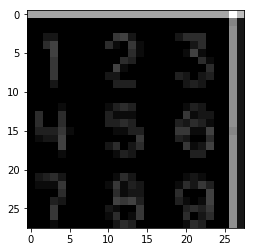

In [97]:
plt.imshow(tensor_images2[13], cmap='gray')


In [98]:
for i in range(len(final_images2)):
    print(final_images2[i].mean())

2.2130102040816326
2.1926020408163267
27.497448979591837
42.50637755102041
34.38137755102041
18.386479591836736
2.1543367346938775
2.2831632653061225
8.623724489795919
2.5395408163265305
2.503826530612245
4.650510204081633
17.872448979591837
17.728316326530614
37.642857142857146
22.002551020408163
2.503826530612245
34.955357142857146
1.778061224489796
28.285714285714285
3.8979591836734695
17.381377551020407
40.6530612244898
18.549744897959183
31.303571428571427
1.7436224489795917
28.85969387755102
44.464285714285715
19.757653061224488
20.917091836734695
24.43877551020408
4.214285714285714
7.281887755102041
19.710459183673468
45.96045918367347
52.55994897959184
17.533163265306122
17.512755102040817
46.50127551020408
26.869897959183675
28.434948979591837
32.63265306122449
41.94387755102041
17.596938775510203
22.81377551020408
45.5625
42.66836734693877
20.644132653061224
5.832908163265306
5.748724489795919
34.55102040816327
19.386479591836736
44.48979591836735
47.985969387755105
32.230867

In [80]:
for i in range(len(tensor_images2)):
    print(tensor_images2[i].mean())

tensor(2.2130)
tensor(2.1926)
tensor(27.4974)
tensor(42.5064)
tensor(34.3814)
tensor(18.3865)
tensor(2.1543)
tensor(2.2832)
tensor(8.6237)
tensor(2.5395)
tensor(2.5038)
tensor(4.6505)
tensor(17.8724)
tensor(17.7283)
tensor(37.6429)
tensor(22.0026)
tensor(2.5038)
tensor(34.9554)
tensor(1.7781)
tensor(28.2857)
tensor(3.8980)
tensor(17.3814)
tensor(40.6531)
tensor(18.5497)
tensor(31.3036)
tensor(1.7436)
tensor(28.8597)
tensor(44.4643)
tensor(19.7577)
tensor(20.9171)
tensor(24.4388)
tensor(4.2143)
tensor(7.2819)
tensor(19.7105)
tensor(45.9605)
tensor(52.5599)
tensor(17.5332)
tensor(17.5128)
tensor(46.5013)
tensor(26.8699)
tensor(28.4349)
tensor(32.6327)
tensor(41.9439)
tensor(17.5969)
tensor(22.8138)
tensor(45.5625)
tensor(42.6684)
tensor(20.6441)
tensor(5.8329)
tensor(5.7487)
tensor(34.5510)
tensor(19.3865)
tensor(44.4898)
tensor(47.9860)
tensor(32.2309)
tensor(27.9145)
tensor(31.5995)
tensor(17.9617)
tensor(17.8380)
tensor(19.1518)
tensor(2.5918)
tensor(2.7526)
tensor(9.0587)
tensor(1.76

In [75]:
convert(tensor_images2)

['.',
 '.',
 '3',
 '8',
 '7',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '1',
 '7',
 '.',
 '5',
 '.',
 '9',
 '.',
 '.',
 '2',
 '.',
 '8',
 '.',
 '8',
 '9',
 '.',
 '.',
 '0',
 '.',
 '.',
 '.',
 '0',
 '8',
 '.',
 '.',
 '8',
 '4',
 '9',
 '6',
 '5',
 '.',
 '2',
 '9',
 '4',
 '.',
 '.',
 '.',
 '5',
 '.',
 '7',
 '2',
 '4',
 '2',
 '7',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '5',
 '4',
 '.',
 '.',
 '.',
 '9',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '4']